Generate the 3:2:1 Crack spread and plot it

/var/folders/56/glwsl01j2jv_87_l49k_p9tw0000gn/T/ipykernel_10319/3869896876.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


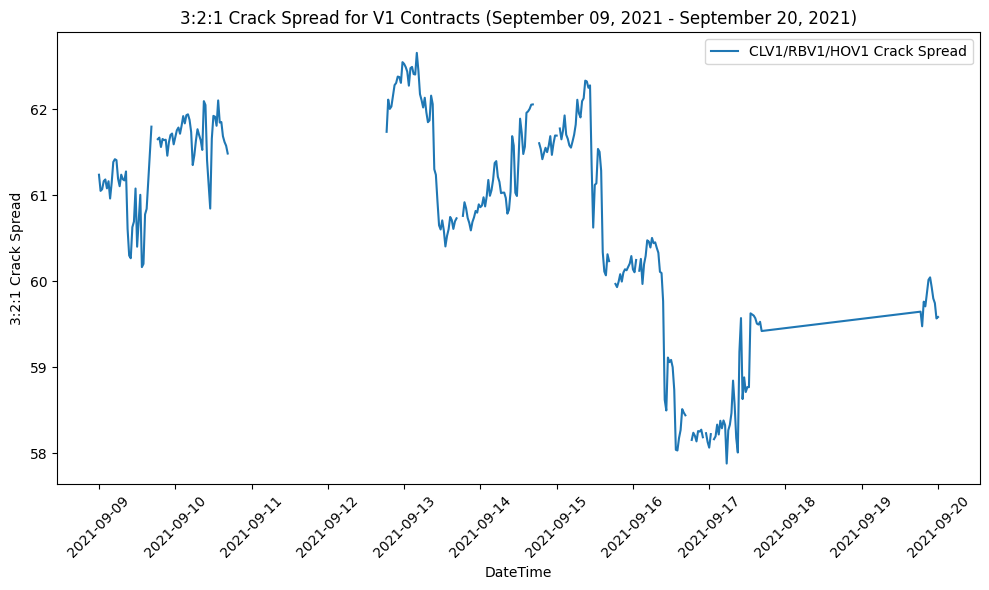

In [1]:
# This code generates the 3:2:1 crack spread, and plots it in a graph for hurricane harvey in August-September 2017. 

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Load data
file_path = 'bins21.csv'
data = pd.read_csv(file_path)

# Convert date and time to a datetime format
data['datetime'] = pd.to_datetime(data['date']) + pd.to_timedelta(data['time'], unit='min')

# Convert HO and RB prices to per barrel
data.loc[data['sym'].str.contains('HO') | data['sym'].str.contains('RB'), ['bid', 'ask', 'prc']] *= 42

# Filter data for the desired date range and specific contracts
start_date = datetime(2021, 9, 9)
end_date = datetime(2021, 9, 20)
filtered_data = data[(data['datetime'] >= start_date) & (data['datetime'] <= end_date)]
# filtered_data = filtered_data[filtered_data['sym'].isin(['CLU7', 'RBU7', 'HOU7', 'CLV7', 'RBV7', 'HOV7'])]
filtered_data = filtered_data[filtered_data['sym'].isin([ 'CLV1', 'RBV1', 'HOV1'])]


# Pivot the data for easier calculation
pivoted_data = filtered_data.pivot_table(index='datetime', columns='sym', values='prc')

# Calculate the 3:2:1 crack spreads
# pivoted_data['crack_spread_U7'] = -1 * (3 * pivoted_data['CLU7'] - 2 * pivoted_data['RBU7'] - pivoted_data['HOU7'])
pivoted_data['crack_spread_V1'] = -1* ( 3 * pivoted_data['CLV1'] - 2 * pivoted_data['RBV1'] - pivoted_data['HOV1'])

# Plotting
plt.figure(figsize=(10, 6))
# plt.plot(pivoted_data.index, pivoted_data['crack_spread_U7'], label='CLU7/RBU7/HOU7 Crack Spread')
plt.plot(pivoted_data.index, pivoted_data['crack_spread_V1'], label='CLV1/RBV1/HOV1 Crack Spread')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation=45)
plt.xlabel('DateTime')
plt.ylabel('3:2:1 Crack Spread')
plt.title(f'3:2:1 Crack Spread for V1 Contracts ({start_date.strftime("%B %d, %Y")} - {end_date.strftime("%B %d, %Y")})')
plt.legend()
plt.tight_layout()
plt.show()



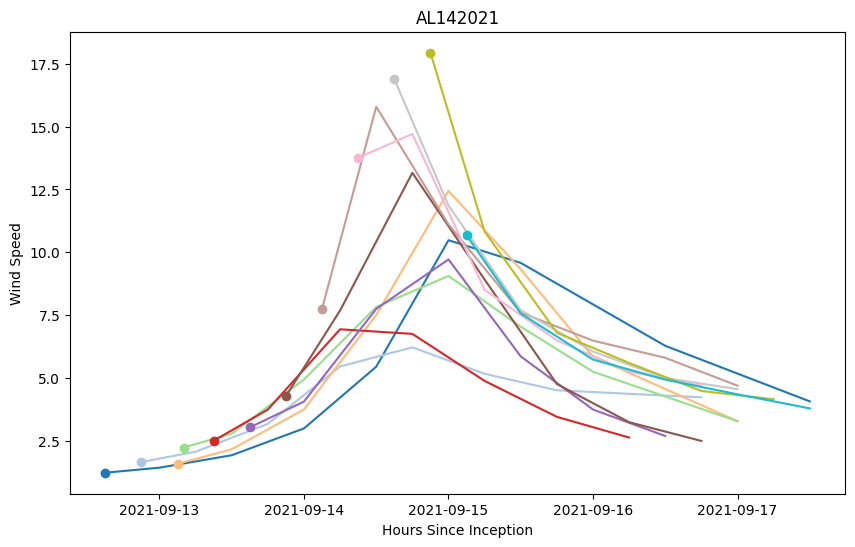

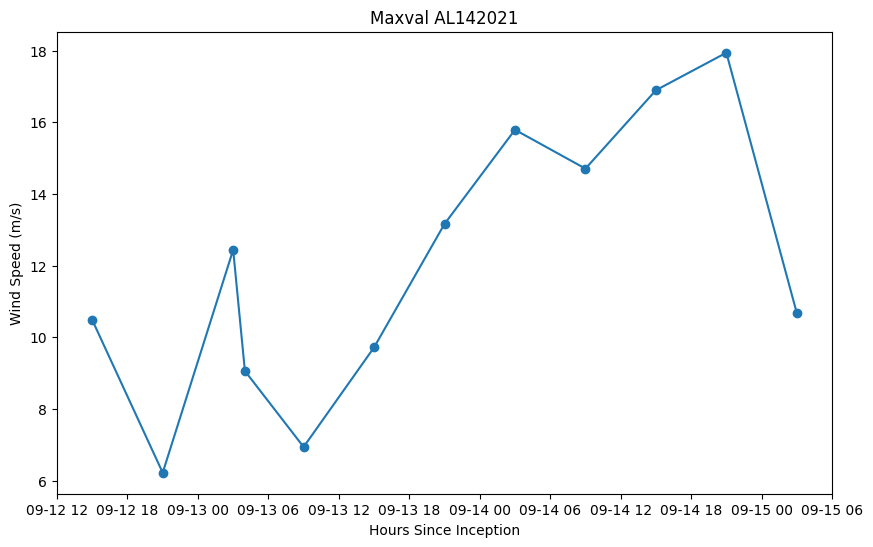

In [2]:
import matplotlib.pyplot as plt
import pickle
from dateutil import parser
import re
from matplotlib import cm
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from datetime import datetime, timedelta
    
# function to define the hurricane score
def wind_speed(distance, v_m, r_m):

    b = 2
    x = 0
    s = 0.5
    x = ((r_m/distance)**b)*np.exp(1-(r_m/distance)**b)

    return v_m*x**s

# function to calculate distance using lat, lon (distance in km)
def distance(loc1, loc2):
    # Approximate radius of earth in km
    R = 6373.0

    lat1 = radians(loc1[0])
    lon1 = radians(loc1[1])
    lat2 = radians(loc2[0])
    lon2 = radians(loc2[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

# define set of functions to predict Rmax8
def calc_f(lat):
    return 2*.00007292*sin(radians(lat))

def calc_mratio(v_max, r_175, lat):
    return 0.699 * np.exp(-0.00618*(v_max - 17.5)-0.00210*(v_max - 17.5)*(1/2*calc_f(lat)*r_175))

def calc_m175(r_175, lat):
    return r_175 * 17.5 + 1/2 * calc_f(lat)*r_175**2

def calc_rmax(v_max, r_175, lat):
    return v_max/(calc_f(lat))*(sqrt(1+2*calc_f(lat)*(calc_m175(r_175, lat)*calc_mratio(v_max, r_175, lat))/(v_max**2))-1)

# define list of storms to plot wind speed

storm_codes = ['AL142021']
month = 9

for storm in storm_codes:
    year = int(storm[-4:])

    with open(f"Data/{year}data.pkl", 'rb') as f:
        x = pickle.load(f)

    galveston = ([29.3013, -94.7977])

    # Initialize inception time (storm inception time)
    inception_time_str = x[storm]['1']['INIT']['Time (UTC)']
    inception_day = int(inception_time_str[:2])
    inception_month = month
    inception_year = year
    inception_hour = 0 # updated later
    inception_time = datetime(inception_year, inception_month, inception_day, inception_hour)

    # set up the figure for each storm
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.title(f"{storm}")
    plt.xlabel("Hours Since Inception")
    plt.ylabel("Wind Speed")

    day_count = 0
    prev28 = 0
    prev29 = 0
    prev30 = 0
    prev31 = 0
    base_day = list(inception_time_str)[0:2]
    base_day = [int(base_day[0]), int(base_day[1])]
    # print("BD1:", base_day)
    max_harr = []
    t_release = []

    for i, key in enumerate(x[storm].keys()):
        times = []
        wind_speeds = []
        lat_arr = []
        lon_arr = []
        hscore_arr = []
        peak_fspeed = 0 # to find the max speed in a given forecast

        for j, key2 in enumerate(x[storm][key].keys()):
        
            # print(key, key2) # for debugging

            if (x[storm][key][key2]['Dissipated?'] != True):

                lat = x[storm][key][key2]['Latitude']
                lon = x[storm][key][key2]['Longitude']
                ws_temp = x[storm][key][key2]['Wind Speed (KT)']   
                
                time_string = list(x[storm][key][key2]['Time (UTC)']) # need to include timing later

                current_day = [int(time_string[0]), int(time_string[1])]
                add31 = 0
                if ((current_day[0] - base_day[0])*10 + (current_day[1] - base_day[1])) < 0:
                    if prev_day == [3,1]:
                        prev31 = 1
                    elif prev_day == [3,0]:
                        prev30 = 1
                    elif prev_day == [2,9]:
                        prev29 = 1
                    elif prev_day == [2,8]:
                        prev28 = 1
                    
                    adds = prev28 * 28 + prev29 * 29 + prev30 * 30 + prev31 * 31
                    day_hrs = ((current_day[0] - base_day[0])*10 + (current_day[1] - base_day[1]) + adds)* 24
                    hour = int(time_string[3]) * 10 + int(time_string[4]) + day_hrs
                    # print(hour)
                    
                    current_datetime = inception_time + timedelta(hours=hour)
                    times.append(current_datetime)
                else:
                    day_hrs = ((current_day[0] - base_day[0])*10 + (current_day[1] - base_day[1]))* 24
                    hour = int(time_string[3]) * 10 + int(time_string[4]) + day_hrs
                    # print(hour)

                    # Extract time and convert to datetime
                    current_datetime = inception_time + timedelta(hours=hour)
                    times.append(current_datetime)
            
                wind_speeds.append(int(ws_temp))

                if (lat[-1] == "N"):
                    lat_arr.append(float(lat[0:-1]))
                elif (lat[-1] == "S"):
                    lat_arr.append(-float(lat[0:-1]))
                if (lon[-1] == "E"):
                    lon_arr.append(float(lon[0:-1]))
                elif (lon[-1] == "W"):
                    lon_arr.append(-float(lon[0:-1]))
                city = galveston
                dist = distance(city, np.array([lat_arr[-1], lon_arr[-1]]))
                windspeed_ms = int(ws_temp) * 0.5144 # change from knots to m/s
                hscore_arr.append(wind_speed(dist, windspeed_ms, calc_rmax(windspeed_ms, 60, lat_arr[-1]))) # calculate

                if (hscore_arr[-1] > peak_fspeed):
                    peak_fspeed = hscore_arr[-1]

                prev_day = current_day
        
        max_harr.append(peak_fspeed)
        t_release.append(times[0])

        colormap = cm.tab20
        color = colormap(i / len(x[storm]))

        # plotting the forecasts
        ax.plot(times[0], hscore_arr[0], marker = "o", color = color)
        ax.plot(times, hscore_arr, color=color, label = key)
        # ax.legend()

    plt.show()

    # max hscore plot per discussion
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    plt.title(f"Maxval {storm}")
    plt.xlabel("Hours Since Inception")
    plt.ylabel("Wind Speed (m/s)")
    ax2.plot(t_release, max_harr, marker = "o")
    plt.show()


    




Results for different lags:
Lag: 0 minutes, R²: 0.15520671789246976, Coefficient: -0.07293108944058588, P-value: 0.230580565390634
Lag: 30 minutes, R²: 0.038971302943738406, Coefficient: -0.03352196402771006, P-value: 0.5606794521993044
Lag: 60 minutes, R²: 0.0034912122364634257, Coefficient: -0.00957690862313833, P-value: 0.8629931473247285
Lag: 90 minutes, R²: 0.0004322970218421096, Coefficient: -0.0031816409085307735, P-value: 0.9516168487600194
Lag: 120 minutes, R²: 0.0012173681369004319, Coefficient: 0.005398371368526934, P-value: 0.9188821695837022
Lag: 150 minutes, R²: 0.06468218368597445, Coefficient: -0.041770977941576616, P-value: 0.5090099745560802
Lag: 180 minutes, R²: 0.05839519826209105, Coefficient: -0.03579776610078787, P-value: 0.5310435603505546
Lag: 210 minutes, R²: 0.008146773825311149, Coefficient: -0.016534867216846192, P-value: 0.7918421744030443
Lag: 240 minutes, R²: 0.0013145958473275154, Coefficient: -0.005698762444471539, P-value: 0.9109291253584899
Lag: 270 

/var/folders/56/glwsl01j2jv_87_l49k_p9tw0000gn/T/ipykernel_10319/1628563654.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Coefficient': ols_results.params[1],
/var/folders/56/glwsl01j2jv_87_l49k_p9tw0000gn/T/ipykernel_10319/1628563654.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'P_value': ols_results.pvalues[1]
/var/folders/56/glwsl01j2jv_87_l49k_p9tw0000gn/T/ipykernel_10319/1628563654.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position,

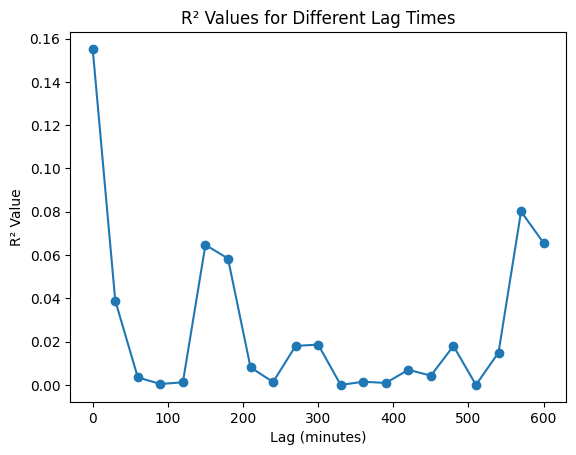

In [8]:
import pandas as pd
from scipy.spatial import KDTree
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Your initial data: max_harr and t_release
# max_harr = [...]
# t_release = [...]

# Define the range of lags to test
lag_range = range(0, 601, 30)  # From 30 to 300 minutes, in steps of 30 minutes

# Dictionary to store results for each lag
results = {}

# Loop over the specified range of lags
for lag_minutes in lag_range:
    # Steps 1 to 5 from your code with adjusted lag
    wind_speed_data = pd.DataFrame({
        'datetime': pd.Series(t_release),
        'max_harr': max_harr
    }).query('max_harr >= 0')

    wind_speed_data['datetime_lagged'] = wind_speed_data['datetime'] + pd.to_timedelta(lag_minutes, unit='min')
    wind_speed_seconds = wind_speed_data['datetime_lagged'].apply(lambda x: x.timestamp()).values

    pivoted_data_seconds = pivoted_data.index.map(lambda x: x.timestamp())
    tree = KDTree(pivoted_data_seconds.values.reshape(-1, 1))
    _, indices = tree.query(wind_speed_seconds.reshape(-1, 1))

    aligned_crack_spreads = pivoted_data['crack_spread_V1'].iloc[indices].values
    wind_speed_data['aligned_crack_spread'] = aligned_crack_spreads
    wind_speed_data = wind_speed_data.dropna()

    # Regression Analysis for each lag
    X = wind_speed_data['max_harr'].values.reshape(-1, 1)
    y = wind_speed_data['aligned_crack_spread']

    X_with_constant = sm.add_constant(X)
    ols_model = sm.OLS(y, X_with_constant)
    ols_results = ols_model.fit()

    # Record results
    results[lag_minutes] = {
        'R_squared': ols_results.rsquared,
        'Coefficient': ols_results.params[1],
        'P_value': ols_results.pvalues[1]
    }

# Print the results for each lag
print("Results for different lags:")
for lag, result in results.items():
    print(f"Lag: {lag} minutes, R²: {result['R_squared']}, Coefficient: {result['Coefficient']}, P-value: {result['P_value']}")

# Optionally, plot the R² values
plt.figure()
plt.plot([lag for lag in results], [result['R_squared'] for result in results.values()], marker='o')
plt.xlabel('Lag (minutes)')
plt.ylabel('R² Value')
plt.title('R² Values for Different Lag Times')
plt.show()


In [ ]:
import statsmodels.api as sm

# Adding a constant to the model for the intercept
X_with_constant = sm.add_constant(X)

# Building the model
model = sm.OLS(y, X_with_constant)

# Fitting the model
results = model.fit()

# Printing the summary statistics
print(results.summary())


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming t_release and pivoted_data.index are already aligned as per your previous instructions
# and 'aligned_crack_spread' contains the corresponding crack spread values

# Plotting
fig, ax1 = plt.subplots()

# Setting up the first axis for crack spread prices
color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Crack Spread Price', color=color)
ax1.plot(pivoted_data.index[indices], aligned_crack_spread, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Setting up the x-axis for dates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Setting up the second axis for max wind speed
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Max Wind Speed (m/s)', color=color)
ax2.plot(t_release_series, max_harr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show plot
fig.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats

# Assuming max_harr and aligned_crack_spread are your data series

# Pearson Correlation
pearson_corr, _ = scipy.stats.pearsonr(max_harr, aligned_crack_spread)
print(f'Pearson Correlation Coefficient: {pearson_corr}')

# Spearman's Rank Correlation
spearman_corr, _ = scipy.stats.spearmanr(max_harr, aligned_crack_spread)
print(f'Spearman Rank Correlation Coefficient: {spearman_corr}')

# Kendall's Tau
kendall_tau, _ = scipy.stats.kendalltau(max_harr, aligned_crack_spread)
print(f'Kendall Tau Coefficient: {kendall_tau}')


Time lag

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Create DataFrame for wind speed data
wind_speed_data = pd.DataFrame({
    't_release': t_release,
    'max_harr': max_harr
})
wind_speed_data.set_index('t_release', inplace=True)

# Align wind speed data with crack spread data
aligned_data = pivoted_data['crack_spread_V7'].to_frame().join(wind_speed_data, how='inner')

# Generate lagged wind speed data
for lag in range(1, 4):
    aligned_data[f'max_harr_lag_{lag}'] = aligned_data['max_harr'].shift(lag)

# Drop rows with NaN values (due to lagging)
aligned_data.dropna(inplace=True)

# Separate dependent and independent variables
X = aligned_data[['max_harr', 'max_harr_lag_1', 'max_harr_lag_2', 'max_harr_lag_3']]
y = aligned_data['crack_spread_V7']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Create a model and fit it
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())


Using only t-1

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Assuming t_release, max_harr, and pivoted_data are already defined in your environment

# Create DataFrame for wind speed data
wind_speed_data = pd.DataFrame({
    't_release': t_release,
    'max_harr': max_harr
})
wind_speed_data.set_index('t_release', inplace=True)

# Align wind speed data with crack spread data
aligned_data = pivoted_data['crack_spread_V7'].to_frame().join(wind_speed_data, how='inner')

# Generate lagged wind speed data for t-1
aligned_data['max_harr_lag_1'] = aligned_data['max_harr'].shift(1)

# Drop rows with NaN values (due to lagging)
aligned_data.dropna(inplace=True)

# Separate dependent and independent variables
X = aligned_data[['max_harr_lag_1']]  # Only the t-1 lagged variable
y = aligned_data['crack_spread_V7']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Create a model and fit it
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())


USING the 1:1 Crack Spread

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Load data
file_path = 'bins17.csv'
data = pd.read_csv(file_path)

# Convert date and time to a datetime format
data['datetime'] = pd.to_datetime(data['date']) + pd.to_timedelta(data['time'], unit='min')

# Convert HO and RB prices to per barrel
data.loc[data['sym'].str.contains('HO') | data['sym'].str.contains('RB'), ['bid', 'ask', 'prc']] *= 42

# Filter data for the desired date range and specific contracts
start_date = datetime(2017, 8, 1)
end_date = datetime(2017, 9, 20)
filtered_data = data[(data['datetime'] >= start_date) & (data['datetime'] <= end_date)]
filtered_data = filtered_data[filtered_data['sym'].isin([ 'CLV7', 'RBV7', 'HOV7'])]


# Pivot the data for easier calculation
pivoted_data = filtered_data.pivot_table(index='datetime', columns='sym', values='prc')

# Calculate the 1:1 crack spread for gasoline
pivoted_data['basic_crack_spread_V7'] = -1* (pivoted_data['CLV7'] - pivoted_data['RBV7'])

# Plotting
plt.figure(figsize=(10, 4))
# plt.plot(pivoted_data.index, pivoted_data['crack_spread_U7'], label='CLU7/RBU7/HOU7 Crack Spread')
plt.plot(pivoted_data.index, pivoted_data['basic_crack_spread_V7'], label='CLV7/RBV7/HOV7 Crack Spread')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation=45)
plt.xlabel('DateTime')
plt.ylabel('1:1 Crack Spread')
plt.title(f'1:1 Crack Spread for RBV7 Contracts ({start_date.strftime("%B %d, %Y")} - {end_date.strftime("%B %d, %Y")})')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from scipy.spatial import KDTree

# Convert t_release to a pandas Series for easier handling
t_release_series = pd.Series(t_release)

# Convert t_release and pivoted_data.index to the same format (e.g., total seconds)
# for KDTree processing
time_format = lambda x: (x - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
t_release_seconds = t_release_series.apply(time_format)
pivoted_data_seconds = pivoted_data.index.map(time_format)

# Build a KDTree for efficient nearest neighbor search
tree = KDTree(pivoted_data_seconds.values.reshape(-1, 1))

# Find the nearest neighbor for each time in t_release
_, indices = tree.query(t_release_seconds.values.reshape(-1, 1))

# Extract the corresponding crack spread values
aligned_crack_spread = pivoted_data['basic_crack_spread_V7'].iloc[indices]


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Ensure that max_harr is a numpy array
max_harr_array = np.array(max_harr)

# Reshape data for sklearn
X = max_harr_array.reshape(-1, 1)
y = aligned_crack_spread.values

# Perform linear regression
model = LinearRegression()
model.fit(X, y)

# Coefficients
print("Slope:", model.coef_[0])
print("Intercept:", model.intercept_)

# Plotting the results
plt.scatter(X, y, color='blue')
plt.plot(X, model.predict(X), color='red')
plt.xlabel('Max Wind Speed')
plt.ylabel('Crack Spread Price')
plt.title('Linear Regression of 1:1 Crack Spread Price on Max Wind Speed')
plt.show()


In [ ]:
import statsmodels.api as sm

# Adding a constant to the model for the intercept
X_with_constant = sm.add_constant(X)

# Building the model
model = sm.OLS(y, X_with_constant)

# Fitting the model
results = model.fit()

# Printing the summary statistics
print(results.summary())


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming t_release and pivoted_data.index are already aligned as per your previous instructions
# and 'aligned_crack_spread' contains the corresponding crack spread values

# Plotting
fig, ax1 = plt.subplots()

# Setting up the first axis for crack spread prices
color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Crack Spread Price', color=color)
ax1.plot(pivoted_data.index[indices], aligned_crack_spread, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Setting up the x-axis for dates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Setting up the second axis for max wind speed
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Max Wind Speed', color=color)
ax2.plot(t_release_series, max_harr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show plot
fig.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats

# Assuming max_harr and aligned_crack_spread are your data series

# Pearson Correlation
pearson_corr, _ = scipy.stats.pearsonr(max_harr, aligned_crack_spread)
print(f'Pearson Correlation Coefficient: {pearson_corr}')

# Spearman's Rank Correlation
spearman_corr, _ = scipy.stats.spearmanr(max_harr, aligned_crack_spread)
print(f'Spearman Rank Correlation Coefficient: {spearman_corr}')

# Kendall's Tau
kendall_tau, _ = scipy.stats.kendalltau(max_harr, aligned_crack_spread)
print(f'Kendall Tau Coefficient: {kendall_tau}')
